In [1]:
# data = {
#     'file': ['E1_front.png', 'E1_side.png', 'E1_top.png', 'E2_front.png', 'E2_side.png', 'E2_top.png'],
#     'lever_tip_x': [525.36, 808.65, 352.30, 594.07, 790.17, 342.84],
#     'lever_tip_y': [446.67, 373.74, 162.13, 446.16, 375.81, 185.17],
#     'upper_lever_tip_x': [506.80, 513.50, 348.21, 583.69, 491.29, 326.91],
#     'upper_lever_tip_y': [109.76, 66.99, 302.43, 119.46, 94.23, 334.09],
#     'stick_head_x': [261.87, 734.33, 501.62, 329.51, 730.67, 493.99],
#     'stick_head_y': [474.28, 463.10, 201.38, 463.98, 454.72, 217.51],
#     'ball_x': [688.95, 759.18, 253.07, 743.19, 743.29, 249.76],
#     'ball_y': [439.52, 350.62, 194.87, 446.19, 360.61, 216.82],
#     'sliding_door_x': [675.83, 638.41, 254.25, 727.62, 641.30, 252.88],
#     'sliding_door_y': [402.94, 350.62, 274.80, 416.66, 365.87, 285.31],
#     'middle_front_x': [308.33, 891.28, 471.89, 366.38, 879.53, 471.87],
#     'middle_front_y': [547.63, 486.68, 122.95, 536.87, 480.34, 144.01],
#     'middle_back_x': [317.01, 256.59, 471.34, 356.72, 246.75, 472.18],
#     'middle_back_y': [402.21, 482.78, 469.96, 401.98, 492.33, 487.91],
#     'left_front_x': [844.89, 891.41, 182.05, 889.03, 868.64, 182.44],
#     'left_front_y': [522.60, 380.02, 118.33, 531.88, 394.87, 140.09]
# }

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D coordinates of the lockbox parts
lock_box_parts = {
    "middle_front": (0, 0, 0),
    "lever_tip": (49, 24, 15),
    "upper_lever_tip": (49, 87, 82),
    "stick_head": (-9, 35, 9),
    "ball": (86, 34, 15),
    "sliding_door": (86, 67, 10),
    "middle_back": (0, 140, 0),
    "left_front": (120, 0, 0)
}

# DataFrame containing the 2D coordinates
data = {
    'file': ['E1_front.png', 'E1_side.png', 'E1_top.png'],
    'lever_tip_x': [525.36, 808.65, 352.30],
    'lever_tip_y': [446.67, 373.74, 162.13],
    'upper_lever_tip_x': [506.80, 513.50, 348.21],
    'upper_lever_tip_y': [109.76, 66.99, 302.43],
    'stick_head_x': [261.87, 734.33, 501.62],
    'stick_head_y': [474.28, 463.10, 201.38],
    'ball_x': [688.95, 759.18, 253.07],
    'ball_y': [439.52, 350.62, 194.87],
    'sliding_door_x': [675.83, 638.41, 254.25],
    'sliding_door_y': [402.94, 350.62, 274.80],
    'middle_front_x': [308.33, 891.28, 471.89],
    'middle_front_y': [547.63, 486.68, 122.95],
    'middle_back_x': [317.01, 256.59, 471.34],
    'middle_back_y': [402.21, 482.78, 469.96],
    'left_front_x': [844.89, 891.41, 182.05],
    'left_front_y': [522.60, 380.02, 118.33]
}

# Convert dictionary to numpy array
points_3d = np.array(list(lock_box_parts.values()), dtype='float32')

df = pd.DataFrame(data)

# Extract 2D points for the front view (E1_front.png)
points_2d_front = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[0].values
points_2d_front = np.vstack((points_2d_front, df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[0].values)).T

points_2d_side = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[1].values
points_2d_side = np.vstack((points_2d_side, df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[1].values)).T

points_2d_top = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[2].values
points_2d_top = np.vstack((points_2d_top, df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[2].values)).T

# Function to calculate camera parameters
def calculate_camera_params(points_3d, points_2d):
    num_points = points_3d.shape[0]
    A = []
    for i in range(num_points):
        X, Y, Z = points_3d[i]
        u, v = points_2d[i]
        A.append([-X, -Y, -Z, -1, 0, 0, 0, 0, u*X, u*Y, u*Z, u])
        A.append([0, 0, 0, 0, -X, -Y, -Z, -1, v*X, v*Y, v*Z, v])
    A = np.array(A)
    
    # Perform SVD
    U, S, Vt = np.linalg.svd(A)
    P = Vt[-1].reshape(3, 4)
    
    # Decompose P to obtain K, R, t
    K, R, t = cv2.decomposeProjectionMatrix(P)[:3]
    K /= K[2, 2]  # Normalize K to make K[2, 2] = 1
    
    # Correct the sign and orientation if needed
    if np.linalg.det(R) < 0:
        R = -R
        t = -t
    
    return K, R, t, P

# Calculate reprojection error
def calculate_reprojection_error(P, points_3d, points_2d):
    num_points = points_3d.shape[0]
    points_2d_reproj = P @ np.hstack((points_3d, np.ones((num_points, 1)))).T
    points_2d_reproj /= points_2d_reproj[2]  # Divide by the last row to normalize
    points_2d_reproj = points_2d_reproj[:2].T
    reprojection_error = np.mean(np.linalg.norm(points_2d - points_2d_reproj, axis=1))
    return reprojection_error

# Calculate camera parameters and reprojection errors for each view
K_front, R_front, t_front, P_front = calculate_camera_params(points_3d, points_2d_front)
reprojection_error_front = calculate_reprojection_error(P_front, points_3d, points_2d_front)

K_side, R_side, t_side, P_side = calculate_camera_params(points_3d, points_2d_side)
reprojection_error_side = calculate_reprojection_error(P_side, points_3d, points_2d_side)

K_top, R_top, t_top, P_top = calculate_camera_params(points_3d, points_2d_top)
reprojection_error_top = calculate_reprojection_error(P_top, points_3d, points_2d_top)
# Correcting the reshaping of 2D points
points_2d_front = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[0:1].values
points_2d_front_y = df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[0:1].values
points_2d_front = np.vstack((points_2d_front, points_2d_front_y)).T

points_2d_side = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[1:2].values
points_2d_side_y = df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[1:2].values
points_2d_side = np.vstack((points_2d_side, points_2d_side_y)).T

points_2d_top = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[2:3].values
points_2d_top_y = df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[2:3].values
points_2d_top = np.vstack((points_2d_top, points_2d_top_y)).T

# Correcting the triangulate_points function to handle reshaped data
def triangulate_points(points_2d_front, points_2d_side, points_2d_top, P_front, P_side, P_top):
    points_3d = []
    for i in range(points_2d_front.shape[0]):
        A = []
        x, y = points_2d_front[i]
        A.append(x * P_front[2, :] - P_front[0, :])
        A.append(y * P_front[2, :] - P_front[1, :])
        
        x, y = points_2d_side[i]
        A.append(x * P_side[2, :] - P_side[0, :])
        A.append(y * P_side[2, :] - P_side[1, :])
        
        x, y = points_2d_top[i]
        A.append(x * P_top[2, :] - P_top[0, :])
        A.append(y * P_top[2, :] - P_top[1, :])
        
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        points_3d.append(X[:3] / X[3])
    return np.array(points_3d)

# Triangulate each point
points_3d_triangulated = triangulate_points(points_2d_front, points_2d_side, points_2d_top, P_front, P_side, P_top)

# Convert to DataFrame for easy viewing
points_3d_df = pd.DataFrame(points_3d_triangulated, columns=['x', 'y', 'z'])

print("front: " + str(reprojection_error_front))
print("side: " + str(reprojection_error_side))
print("top: " + str(reprojection_error_top))
points_3d_df

front: 5.075134302964106
side: 5.684909410764384
top: 1.881206493517923


,x,y,z
0,0.463523,-0.002697,0.284232
1,49.226006,22.624102,16.136633
2,48.948935,86.912540,81.881655
3,-9.750026,35.745471,8.955858
4,86.830082,35.510132,12.547386
5,85.592179,66.798492,12.969218
6,0.014195,140.027187,-0.959975
7,119.656229,-0.519018,-0.712708


In [3]:
lock_box_parts = {
    "middle_front": (0, 0, 0),
    "lever_tip": (49, 24, 15),
    "upper_lever_tip": (49, 87, 82),
    "stick_head": (-9, 35, 9),
    "ball": (86, 34, 15),
    "sliding_door": (86, 67, 10),
    "middle_back": (0, 140, 0),
    "right_front": (120, 0, 0)
}

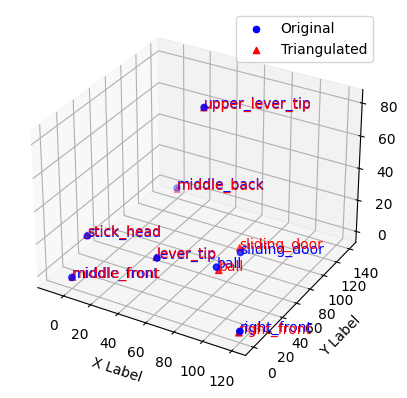

In [4]:
# Visualization with square bounding boxes
def visualize_3d_points_with_square_bounding_boxes(original_points, triangulated_points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for original points
    ax.scatter(original_points[:, 0], original_points[:, 1], original_points[:, 2], c='b', marker='o', label='Original')

    # Scatter plot for triangulated points
    ax.scatter(triangulated_points[:, 0], triangulated_points[:, 1], triangulated_points[:, 2], c='r', marker='^', label='Triangulated')

    # Labeling the points (assuming the order matches the parts' names)
    #part_names = ["lever_tip", "upper_lever_tip", "stick_head", "ball", "sliding_door"]
    part_names = ["middle_front", "lever_tip", "upper_lever_tip", "stick_head", "ball", "sliding_door", "middle_back", "right_front"]
    
    for i, part_name in enumerate(part_names):
        ax.text(original_points[i, 0], original_points[i, 1], original_points[i, 2], part_name, color='blue')
        
    # Add labels to the triangulated points
    for i, part_name in enumerate(part_names):
        ax.text(triangulated_points[i, 0], triangulated_points[i, 1], triangulated_points[i, 2], part_name, color='red')

    

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.legend()

    plt.show()

# Call the function to visualize the points with square bounding boxes
visualize_3d_points_with_square_bounding_boxes(points_3d, points_3d_triangulated)

In [5]:
import pandas as pd

# Path to the HDF5 file
hdf5_path_front = '/home/box/coding/CTIR/videos/experiment_1/E1_frontDLC_resnet101_Moused_2Jul5shuffle1_10000.h5'
hdf5_path_side = '/home/box/coding/CTIR/videos/experiment_1/E1_sideDLC_resnet101_Moused_2Jul5shuffle1_10000.h5'
hdf5_path_top = '/home/box/coding/CTIR/videos/experiment_1/E1_topDLC_resnet101_Moused_2Jul5shuffle1_10000.h5'

# Load the data
data_f = pd.read_hdf(hdf5_path_front)
data_s = pd.read_hdf(hdf5_path_side)
data_t = pd.read_hdf(hdf5_path_top)

columns_to_keep = ['nose', 'ear_left', 'ear_right','body_center','tail_base']

data_f = data_f.loc[:, data_f.columns.get_level_values(1).isin(columns_to_keep)]
data_s = data_s.loc[:, data_s.columns.get_level_values(1).isin(columns_to_keep)]
data_t = data_t.loc[:, data_t.columns.get_level_values(1).isin(columns_to_keep)]

data_f.columns = data_f.columns.droplevel(0)
data_s.columns = data_s.columns.droplevel(0)
data_t.columns = data_t.columns.droplevel(0)

data_f.columns = data_f.columns.map('_'.join).str.strip('|')
data_s.columns = data_s.columns.map('_'.join).str.strip('|')
data_t.columns = data_t.columns.map('_'.join).str.strip('|')


In [6]:
data_f

,nose_x,nose_y,nose_likelihood,ear_left_x,ear_left_y,ear_left_likelihood,ear_right_x,ear_right_y,ear_right_likelihood,body_center_x,body_center_y,body_center_likelihood,tail_base_x,tail_base_y,tail_base_likelihood
0,868.920532,542.014587,0.000497,894.719177,565.795471,0.000631,896.455750,567.631775,0.000174,864.877502,540.738525,0.000115,862.459778,541.398926,0.000041
1,869.007202,541.922546,0.000543,894.698486,565.783691,0.000656,896.444275,567.548035,0.000187,865.130066,540.757263,0.000113,862.786987,541.426147,0.000040
2,868.936768,542.005188,0.000557,894.697754,565.739868,0.000654,896.440918,567.502930,0.000179,865.017090,540.817505,0.000108,862.622375,541.413513,0.000039
3,868.937439,542.005676,0.000557,894.699097,565.740906,0.000656,896.441101,567.502869,0.000179,865.017822,540.820129,0.000107,862.627869,541.414429,0.000039
4,868.918030,542.012146,0.000555,894.706360,565.739807,0.000657,896.442749,567.504211,0.000180,865.006409,540.792053,0.000112,862.600342,541.437195,0.000040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16645,660.123169,388.970184,0.083187,710.646973,259.358948,0.726288,635.375244,269.005676,0.983060,698.122498,248.929596,0.012591,675.580444,366.229340,0.005373
16646,667.532532,221.880615,0.005777,711.467651,253.495026,0.844688,635.979065,262.867554,0.991955,698.166992,251.470688,0.008062,717.502625,252.227570,0.010308
16647,696.364868,231.913284,0.008851,712.881042,249.502151,0.129862,636.126709,258.645905,0.983849,657.101868,235.970337,0.004724,699.961914,247.946793,0.004029
16648,698.366943,232.865738,0.005748,713.498169,248.744370,0.041426,715.267212,246.693573,0.993513,620.215149,307.886719,0.004907,699.645508,247.846191,0.004447


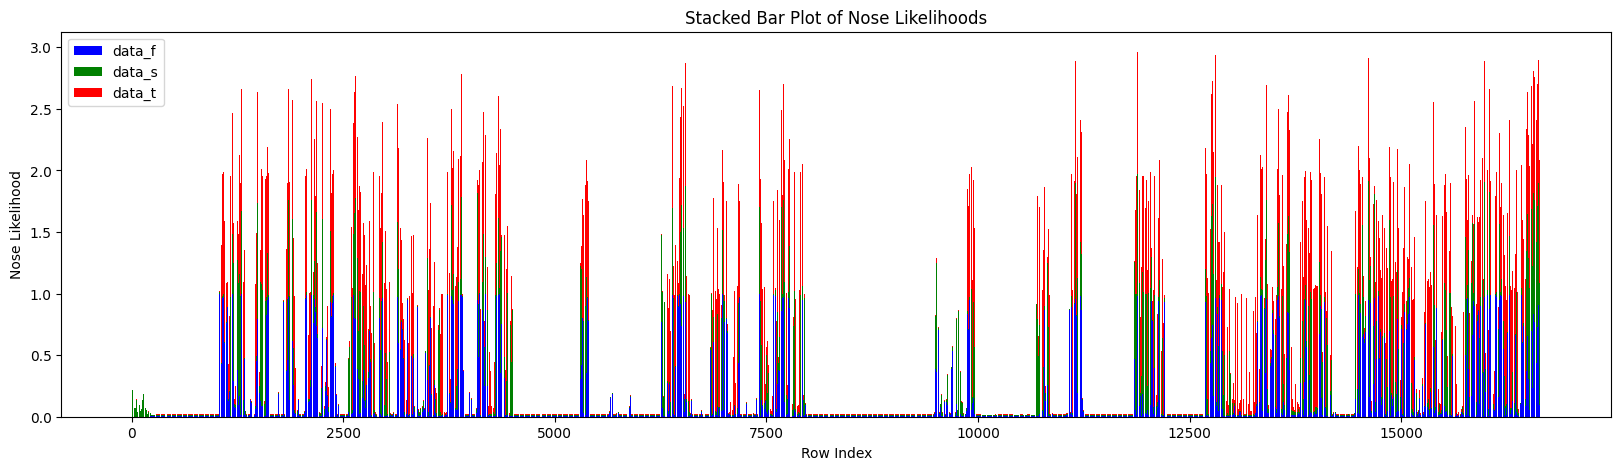

In [7]:
# Assuming data_f, data_s, and data_t are your DataFrames and have the same number of rows
rows = len(data_f)
indices = range(rows)

# Get nose_likelihood values
nose_f = data_f["nose_likelihood"].tolist()
nose_s = data_s["nose_likelihood"].tolist()
nose_t = data_t["nose_likelihood"].tolist()

# Create the bar plot
indices = range(len(nose_f))
plt.figure(figsize=(20, 5))
plt.bar(indices, nose_f, color='b', label='data_f')
plt.bar(indices, nose_s, bottom=nose_f, color='g', label='data_s')
plt.bar(indices, nose_t, bottom=[i+j for i,j in zip(nose_f, nose_s)], color='r', label='data_t')

# Add labels
plt.xlabel('Row Index')
plt.ylabel('Nose Likelihood')
plt.title('Stacked Bar Plot of Nose Likelihoods')
plt.legend()

plt.show()

In [8]:
# def weighted_triangulate_points(points_2d_front, points_2d_side, points_2d_top, P_front, P_side, P_top, likelihoods):
#     points_3d = []
#     for i in range(points_2d_front.shape[0]):
#         A = []
        
#         x, y = points_2d_front[i]
#         A.append(likelihoods['front'][i] * (x * P_front[2, :] - P_front[0, :]))
#         A.append(likelihoods['front'][i] * (y * P_front[2, :] - P_front[1, :]))
        
#         x, y = points_2d_side[i]
#         A.append(likelihoods['side'][i] * (x * P_side[2, :] - P_side[0, :]))
#         A.append(likelihoods['side'][i] * (y * P_side[2, :] - P_side[1, :]))
        
#         x, y = points_2d_top[i]
#         A.append(likelihoods['top'][i] * (x * P_top[2, :] - P_top[0, :]))
#         A.append(likelihoods['top'][i] * (y * P_top[2, :] - P_top[1, :]))
        
#         A = np.array(A)
#         _, _, Vt = np.linalg.svd(A)
#         X = Vt[-1]
#         points_3d.append(X[:3] / X[3])
    
#     return np.array(points_3d)


In [9]:
import numpy as np

def weighted_triangulate_points(points_2d_front, points_2d_side, points_2d_top, P_front, P_side, P_top, likelihoods):
    points_3d = []
    for i in range(points_2d_front.shape[0]):
        A = []
        
        x, y = points_2d_front[i]
        A.append(likelihoods['front'][i] * (x * P_front[2, :] - P_front[0, :]))
        A.append(likelihoods['front'][i] * (y * P_front[2, :] - P_front[1, :]))
        
        x, y = points_2d_side[i]
        A.append(likelihoods['side'][i] * (x * P_side[2, :] - P_side[0, :]))
        A.append(likelihoods['side'][i] * (y * P_side[2, :] - P_side[1, :]))
        
        x, y = points_2d_top[i]
        A.append(likelihoods['top'][i] * (x * P_top[2, :] - P_top[0, :]))
        A.append(likelihoods['top'][i] * (y * P_top[2, :] - P_top[1, :]))
        
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        points_3d.append(X[:3] / X[3])
    
    return np.array(points_3d)


In [10]:
# def triangulate_points(points_2d_front, points_2d_side, points_2d_top, P_front, P_side, P_top):
#     points_3d = []
#     for i in range(points_2d_front.shape[0]):
#         A = []
#         x, y = points_2d_front[i]
#         A.append(x * P_front[2, :] - P_front[0, :])
#         A.append(y * P_front[2, :] - P_front[1, :])
        
#         x, y = points_2d_side[i]
#         A.append(x * P_side[2, :] - P_side[0, :])
#         A.append(y * P_side[2, :] - P_side[1, :])
        
#         x, y = points_2d_top[i]
#         A.append(x * P_top[2, :] - P_top[0, :])
#         A.append(y * P_top[2, :] - P_top[1, :])
        
#         A = np.array(A)
#         _, _, Vt = np.linalg.svd(A)
#         X = Vt[-1]
#         points_3d.append(X[:3] / X[3])
#     return np.array(points_3d)

In [11]:
def triangle_area_3d(A, B, C):
    # Convert points to numpy arrays
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)
    
    # Compute the vectors AB and AC
    AB = B - A
    AC = C - A
    
    # Compute the cross product of AB and AC
    cross_product = np.cross(AB, AC)
    
    # Compute the magnitude of the cross product
    area = np.linalg.norm(cross_product) / 2.0
    
    return area
def triangle_centroid_3d(A, B, C):
    # Convert points to numpy arrays
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)
    
    # Compute the centroid
    centroid = (A + B + C) / 3.0
    
    return centroid
# Convert data to 2D arrays
nose_f = np.column_stack((data_f['nose_x'], data_f['nose_y']))
nose_s = np.column_stack((data_s['nose_x'], data_s['nose_y']))
nose_t = np.column_stack((data_t['nose_x'], data_t['nose_y']))

ear_l_f = np.column_stack((data_f['ear_left_x'], data_f['ear_left_y']))
ear_l_s = np.column_stack((data_s['ear_left_x'], data_s['ear_left_y']))
ear_l_t = np.column_stack((data_t['ear_left_x'], data_t['ear_left_y']))

ear_r_f = np.column_stack((data_f['ear_right_x'], data_f['ear_right_y']))
ear_r_s = np.column_stack((data_s['ear_right_x'], data_s['ear_right_y']))
ear_r_t = np.column_stack((data_t['ear_right_x'], data_t['ear_right_y']))

nose_lks = pd.DataFrame({'front':data_f['nose_likelihood'],'side':data_s['nose_likelihood'], 'top':data_t['nose_likelihood']})
ear_l_lks = pd.DataFrame({'front':data_f['ear_left_likelihood'],'side':data_s['ear_left_likelihood'], 'top':data_t['ear_left_likelihood']})
ear_r_lks = pd.DataFrame({'front':data_f['ear_right_likelihood'],'side':data_s['ear_right_likelihood'], 'top':data_t['ear_right_likelihood']})

# Triangulate points
nose_3d = weighted_triangulate_points(nose_f, nose_s, nose_t, P_front, P_side, P_top, nose_lks)
ear_l_3d = weighted_triangulate_points(ear_l_f, ear_l_s, ear_l_t, P_front, P_side, P_top, ear_l_lks)
ear_r_3d = weighted_triangulate_points(ear_r_f, ear_r_s, ear_r_t, P_front, P_side, P_top, ear_r_lks)

mouse_triangle = []
t_x = []
t_y = []
t_z = []
nose_likelihood = []
ear_left_likelihood = []
ear_right_likelihood = []

# Loop to calculate values and append to lists
for i in range(len(nose_3d)):
    x,y,z = triangle_centroid_3d(nose_3d[i], ear_l_3d[i], ear_r_3d[i])
    mouse_triangle.append(triangle_area_3d(nose_3d[i], ear_l_3d[i], ear_r_3d[i]))
    t_x.append(x)
    t_y.append(y)
    t_z.append(z)
    nose_likelihood.append(data_f['nose_likelihood'][i] + data_s['nose_likelihood'][i] + data_t['nose_likelihood'][i])
    ear_left_likelihood.append(data_f['ear_left_likelihood'][i] + data_s['ear_left_likelihood'][i] + data_t['ear_left_likelihood'][i])
    ear_right_likelihood.append(data_f['ear_right_likelihood'][i] + data_s['ear_right_likelihood'][i] + data_t['ear_right_likelihood'][i])


In [12]:
nose_3d

array([[43.90713959, 95.62568273, 13.54509409],
       [51.52540332, 96.85119344, 11.75922257],
       [53.7587675 , 97.22344874, 11.21775255],
       ...,
       [90.91902827, 71.49083511, 23.27391081],
       [91.35975866, 71.5335418 , 23.13897501],
       [91.06833628, 71.7842684 , 24.38945599]])

In [13]:
ear_r_lks

,front,side,top
0,0.000174,0.009064,0.373170
1,0.000187,0.007295,0.370460
2,0.000179,0.007964,0.368077
3,0.000179,0.009588,0.367421
4,0.000180,0.007640,0.374651
...,...,...,...
16645,0.983060,0.004904,0.996079
16646,0.991955,0.016031,0.994754
16647,0.983849,0.016519,0.991762
16648,0.993513,0.017919,0.983271


In [14]:
likelihood_show = pd.DataFrame({
    'mouse_triangle': mouse_triangle,
    'x':t_x,
    'y':t_y,
    'z':t_z,
    'nose_likelihood': nose_likelihood,
    'ear_left_likelihood': ear_left_likelihood,
    'ear_right_likelihood': ear_right_likelihood
})

In [15]:

likelihood_show['total_likelihood'] = likelihood_show[['nose_likelihood', 'ear_left_likelihood', 'ear_right_likelihood']].sum(axis=1)
likelihood_show['hits'] = likelihood_show[['nose_likelihood', 'ear_left_likelihood', 'ear_right_likelihood']].gt(1.5).sum(axis=1)

likelihood_show['f_n'] = data_f['nose_likelihood']
likelihood_show['s_n'] = data_s['nose_likelihood']
likelihood_show['t_n'] = data_t['nose_likelihood']

likelihood_show['f_e_l'] = data_f['ear_left_likelihood']
likelihood_show['s_e_l'] = data_s['ear_left_likelihood']
likelihood_show['t_e_l'] = data_t['ear_left_likelihood']

likelihood_show['f_e_r'] = data_f['ear_right_likelihood']
likelihood_show['s_e_r'] = data_s['ear_right_likelihood']
likelihood_show['t_e_r'] = data_t['ear_right_likelihood']

likelihood_show

,mouse_triangle,x,y,z,nose_likelihood,ear_left_likelihood,ear_right_likelihood,total_likelihood,hits,f_n,s_n,t_n,f_e_l,s_e_l,t_e_l,f_e_r,s_e_r,t_e_r
0,510.143797,18.293333,98.032958,28.304527,0.232079,0.082116,0.382408,0.696603,0,0.000497,0.230038,0.001543,0.000631,0.001838,0.079648,0.000174,0.009064,0.373170
1,862.022677,21.506125,98.527262,31.275892,0.234335,0.081843,0.377942,0.694119,0,0.000543,0.232300,0.001492,0.000656,0.001626,0.079561,0.000187,0.007295,0.370460
2,900.636488,22.253137,98.650836,31.115947,0.204676,0.081438,0.376221,0.662335,0,0.000557,0.202638,0.001481,0.000654,0.001619,0.079165,0.000179,0.007964,0.368077
3,532.066075,21.197166,98.494374,26.504290,0.239928,0.082482,0.377188,0.699598,0,0.000557,0.237879,0.001492,0.000656,0.002052,0.079774,0.000179,0.009588,0.367421
4,521.529149,19.820599,98.245211,27.262543,0.413909,0.086666,0.382471,0.883045,0,0.000555,0.411766,0.001588,0.000657,0.001990,0.084018,0.000180,0.007640,0.374651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16645,204.458310,86.876938,80.325598,37.427995,2.069458,1.473258,1.984043,5.526758,2,0.083187,0.994172,0.992098,0.726288,0.056665,0.690304,0.983060,0.004904,0.996079
16646,219.130509,87.319552,81.059413,38.261472,1.993340,1.529322,2.002739,5.525402,3,0.005777,0.993405,0.994158,0.844688,0.083980,0.600655,0.991955,0.016031,0.994754
16647,234.516213,87.757644,81.705175,38.242653,1.998704,0.542906,1.992130,4.533740,2,0.008851,0.993608,0.996245,0.129862,0.078593,0.334450,0.983849,0.016519,0.991762
16648,86.655943,92.426933,81.952631,37.895589,1.995955,0.497924,1.994703,4.488582,2,0.005748,0.993863,0.996344,0.041426,0.087129,0.369369,0.993513,0.017919,0.983271


In [16]:
likelihood_show['h_n'] = likelihood_show[['f_n', 's_n', 't_n']].gt(0.7).sum(axis=1)
likelihood_show['h_e_l'] = likelihood_show[['f_e_l', 's_e_l', 't_e_l']].gt(0.7).sum(axis=1)
likelihood_show['h_e_r'] = likelihood_show[['f_e_r', 's_e_r', 't_e_r']].gt(0.7).sum(axis=1)
likelihood_show['h_sub'] = likelihood_show[['h_n', 'h_e_l', 'h_e_r']].sum(axis=1)
likelihood_show['low'] = likelihood_show[['h_n', 'h_e_l', 'h_e_r']].min(axis=1)

likelihood_show

,mouse_triangle,x,y,z,nose_likelihood,ear_left_likelihood,ear_right_likelihood,total_likelihood,hits,f_n,...,s_e_l,t_e_l,f_e_r,s_e_r,t_e_r,h_n,h_e_l,h_e_r,h_sub,low
0,510.143797,18.293333,98.032958,28.304527,0.232079,0.082116,0.382408,0.696603,0,0.000497,...,0.001838,0.079648,0.000174,0.009064,0.373170,0,0,0,0,0
1,862.022677,21.506125,98.527262,31.275892,0.234335,0.081843,0.377942,0.694119,0,0.000543,...,0.001626,0.079561,0.000187,0.007295,0.370460,0,0,0,0,0
2,900.636488,22.253137,98.650836,31.115947,0.204676,0.081438,0.376221,0.662335,0,0.000557,...,0.001619,0.079165,0.000179,0.007964,0.368077,0,0,0,0,0
3,532.066075,21.197166,98.494374,26.504290,0.239928,0.082482,0.377188,0.699598,0,0.000557,...,0.002052,0.079774,0.000179,0.009588,0.367421,0,0,0,0,0
4,521.529149,19.820599,98.245211,27.262543,0.413909,0.086666,0.382471,0.883045,0,0.000555,...,0.001990,0.084018,0.000180,0.007640,0.374651,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16645,204.458310,86.876938,80.325598,37.427995,2.069458,1.473258,1.984043,5.526758,2,0.083187,...,0.056665,0.690304,0.983060,0.004904,0.996079,2,1,2,5,1
16646,219.130509,87.319552,81.059413,38.261472,1.993340,1.529322,2.002739,5.525402,3,0.005777,...,0.083980,0.600655,0.991955,0.016031,0.994754,2,1,2,5,1
16647,234.516213,87.757644,81.705175,38.242653,1.998704,0.542906,1.992130,4.533740,2,0.008851,...,0.078593,0.334450,0.983849,0.016519,0.991762,2,0,2,4,0
16648,86.655943,92.426933,81.952631,37.895589,1.995955,0.497924,1.994703,4.488582,2,0.005748,...,0.087129,0.369369,0.993513,0.017919,0.983271,2,0,2,4,0


In [17]:
print(len(likelihood_show[(likelihood_show['low'] > 0)]))
print(len(likelihood_show[(likelihood_show['low'] > 1)]))
print(len(likelihood_show[(likelihood_show['low'] > 2)]))

5267
1742
90


In [18]:
# get max distance difference of mouse movement in video
import math

def distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2 + (coord1[2] - coord2[2])**2)

d = []
for i in range(len(likelihood_show) - 1):
    if(likelihood_show.iloc[i]['low'] < 2 or likelihood_show.iloc[i+1]['low'] < 2):
        d.append(0)
    else:
        dist = distance(
            [likelihood_show.iloc[i]['x'], likelihood_show.iloc[i]['y'], likelihood_show.iloc[i]['z']], 
            [likelihood_show.iloc[i+1]['x'], likelihood_show.iloc[i+1]['y'], likelihood_show.iloc[i+1]['z']]
        )
        d.append(dist)              
d.append(0)

In [19]:
likelihood_show['dist'] = d
likelihood_show

,mouse_triangle,x,y,z,nose_likelihood,ear_left_likelihood,ear_right_likelihood,total_likelihood,hits,f_n,...,t_e_l,f_e_r,s_e_r,t_e_r,h_n,h_e_l,h_e_r,h_sub,low,dist
0,510.143797,18.293333,98.032958,28.304527,0.232079,0.082116,0.382408,0.696603,0,0.000497,...,0.079648,0.000174,0.009064,0.373170,0,0,0,0,0,0.0
1,862.022677,21.506125,98.527262,31.275892,0.234335,0.081843,0.377942,0.694119,0,0.000543,...,0.079561,0.000187,0.007295,0.370460,0,0,0,0,0,0.0
2,900.636488,22.253137,98.650836,31.115947,0.204676,0.081438,0.376221,0.662335,0,0.000557,...,0.079165,0.000179,0.007964,0.368077,0,0,0,0,0,0.0
3,532.066075,21.197166,98.494374,26.504290,0.239928,0.082482,0.377188,0.699598,0,0.000557,...,0.079774,0.000179,0.009588,0.367421,0,0,0,0,0,0.0
4,521.529149,19.820599,98.245211,27.262543,0.413909,0.086666,0.382471,0.883045,0,0.000555,...,0.084018,0.000180,0.007640,0.374651,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16645,204.458310,86.876938,80.325598,37.427995,2.069458,1.473258,1.984043,5.526758,2,0.083187,...,0.690304,0.983060,0.004904,0.996079,2,1,2,5,1,0.0
16646,219.130509,87.319552,81.059413,38.261472,1.993340,1.529322,2.002739,5.525402,3,0.005777,...,0.600655,0.991955,0.016031,0.994754,2,1,2,5,1,0.0
16647,234.516213,87.757644,81.705175,38.242653,1.998704,0.542906,1.992130,4.533740,2,0.008851,...,0.334450,0.983849,0.016519,0.991762,2,0,2,4,0,0.0
16648,86.655943,92.426933,81.952631,37.895589,1.995955,0.497924,1.994703,4.488582,2,0.005748,...,0.369369,0.993513,0.017919,0.983271,2,0,2,4,0,0.0


# if lowest common observation likelihoods passing threshold is < 2, ignore the measurement. use the resulting max distance as max speed of mouse.

In [20]:
likelihood_show[likelihood_show['dist'] == likelihood_show['dist'].max()]

,mouse_triangle,x,y,z,nose_likelihood,ear_left_likelihood,ear_right_likelihood,total_likelihood,hits,f_n,...,t_e_l,f_e_r,s_e_r,t_e_r,h_n,h_e_l,h_e_r,h_sub,low,dist
2910,126.110765,53.514729,36.543827,59.66995,1.972753,2.134958,2.597055,6.704766,3,0.891356,...,0.922037,0.666053,0.981411,0.949591,2,2,2,6,2,21.605715


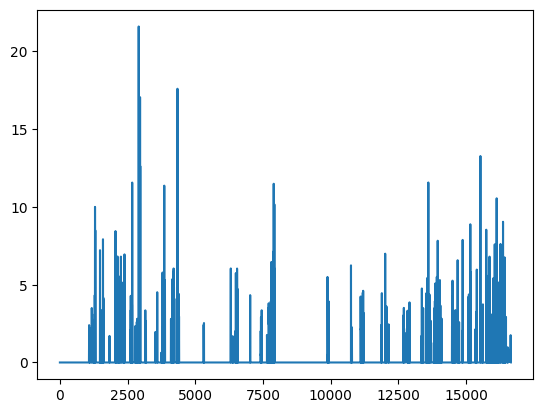

In [21]:
plt.plot(d)

In [22]:
max_d = likelihood_show['dist'].max()
len(likelihood_show[(likelihood_show['dist'] <= max_d)&(likelihood_show['dist'] > 0)])

1265

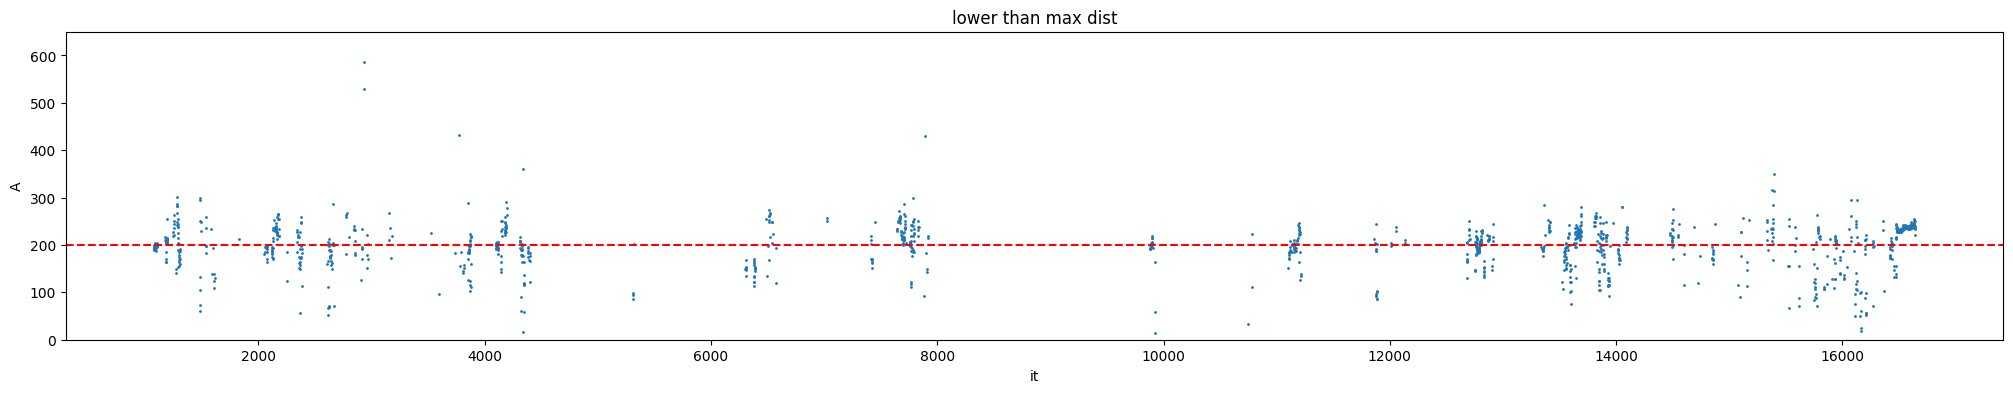

In [23]:
import matplotlib.pyplot as plt

# Assuming mouse_triangle is already defined
plt.figure(figsize=(25, 4))

# plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2) & (likelihood_show['mouse_triangle'] > 200)].sort_values(by='total_likelihood')
plot_df = likelihood_show[(likelihood_show['dist'] <= max_d)&(likelihood_show['dist'] > 0)]
#plot_df = likelihood_show#.sort_values(by='total_likelihood')

plt.scatter(plot_df.index, plot_df['mouse_triangle'], s=1)

# Add labels and title
plt.xlabel('it')
plt.ylabel('A')
plt.title('lower than max dist')

plt.ylim(0, 650)
# Define the threshold
threshold = 200

plt.axhline(y=threshold, color='r', linestyle='--')
# Show plot
plt.show()


# check out lowest common observation likelihood hits

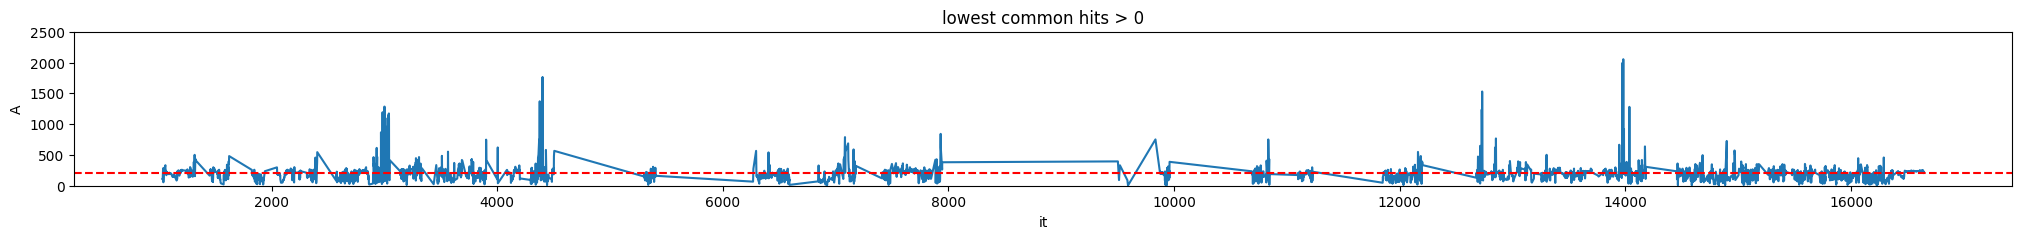

In [24]:
import matplotlib.pyplot as plt

# Assuming mouse_triangle is already defined
plt.figure(figsize=(25, 2))

# plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2) & (likelihood_show['mouse_triangle'] > 200)].sort_values(by='total_likelihood')
plot_df = likelihood_show[(likelihood_show['low'] > 0)]
#plot_df = likelihood_show#.sort_values(by='total_likelihood')

plt.plot(plot_df['mouse_triangle'])

# Add labels and title
plt.xlabel('it')
plt.ylabel('A')
plt.title('lowest common hits > 0')

plt.ylim(0, 2500)
# Define the threshold
threshold = 200

plt.axhline(y=threshold, color='r', linestyle='--')
# Show plot
plt.show()


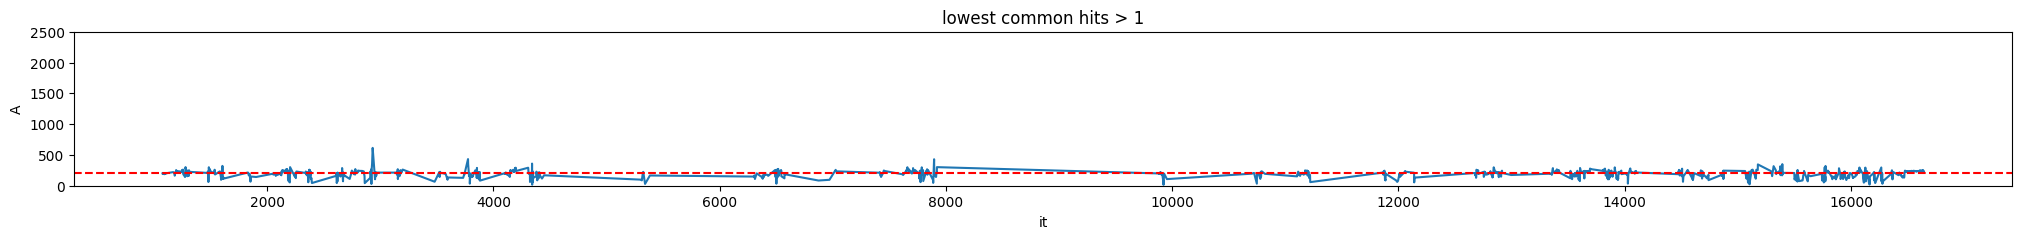

In [25]:
import matplotlib.pyplot as plt

# Assuming mouse_triangle is already defined
plt.figure(figsize=(25, 2))

# plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2) & (likelihood_show['mouse_triangle'] > 200)].sort_values(by='total_likelihood')
plot_df = likelihood_show[(likelihood_show['low'] > 1)]
#plot_df = likelihood_show#.sort_values(by='total_likelihood')

plt.plot(plot_df['mouse_triangle'])

# Add labels and title
plt.xlabel('it')
plt.ylabel('A')
plt.title('lowest common hits > 1')

plt.ylim(0, 2500)
# Define the threshold
threshold = 200

plt.axhline(y=threshold, color='r', linestyle='--')
# Show plot
plt.show()


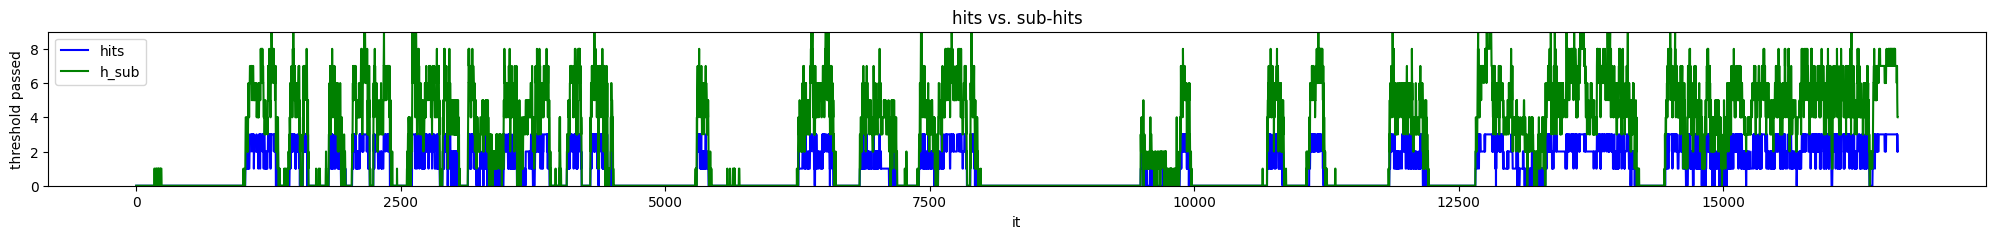

In [26]:
import matplotlib.pyplot as plt

# Assuming mouse_triangle is already defined
plt.figure(figsize=(25, 2))

# plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2) & (likelihood_show['mouse_triangle'] > 200)].sort_values(by='total_likelihood')
plot_df = likelihood_show
#plot_df = likelihood_show#.sort_values(by='total_likelihood')

#plt.plot(mouse_triangle)
#plt.plot(plot_df['total_likelihood'],plot_df['mouse_triangle'])
plt.plot(plot_df['hits'], label='hits', color='b')
plt.plot(plot_df['h_sub'], label='h_sub', color='g')

# Add labels and title
plt.xlabel('it')
plt.ylabel('threshold passed')
plt.title('hits vs. sub-hits')

# Cut off y axis at 20000
plt.ylim(0, 9)
# Define the threshold
plt.legend()

# Show plot
plt.show()


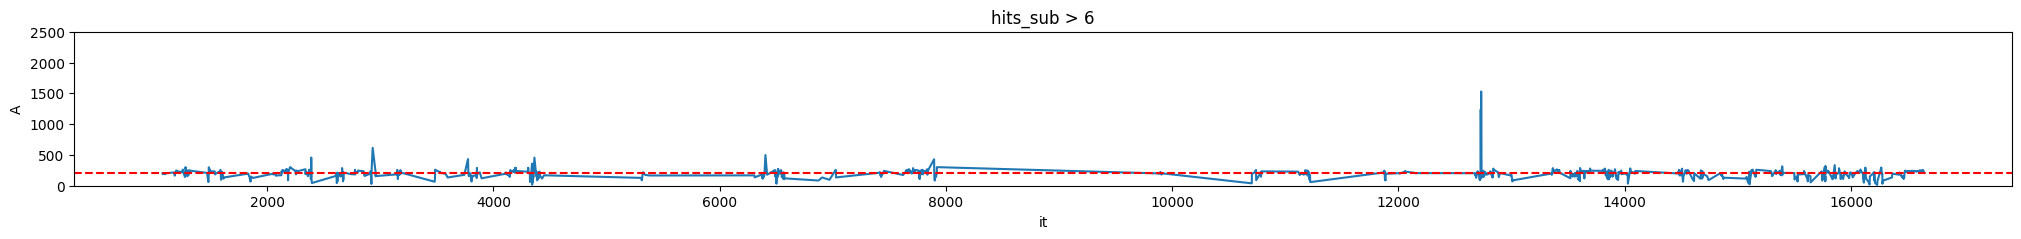

In [27]:
import matplotlib.pyplot as plt

# Assuming mouse_triangle is already defined
plt.figure(figsize=(25, 2))

# plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2) & (likelihood_show['mouse_triangle'] > 200)].sort_values(by='total_likelihood')
plot_df = likelihood_show[(likelihood_show['h_sub'] > 6)]
#plot_df = likelihood_show#.sort_values(by='total_likelihood')

plt.plot(plot_df['mouse_triangle'])

# Add labels and title
plt.xlabel('it')
plt.ylabel('A')
plt.title('hits_sub > 6')

plt.ylim(0, 2500)
# Define the threshold
threshold = 200

plt.axhline(y=threshold, color='r', linestyle='--')
# Show plot
plt.show()


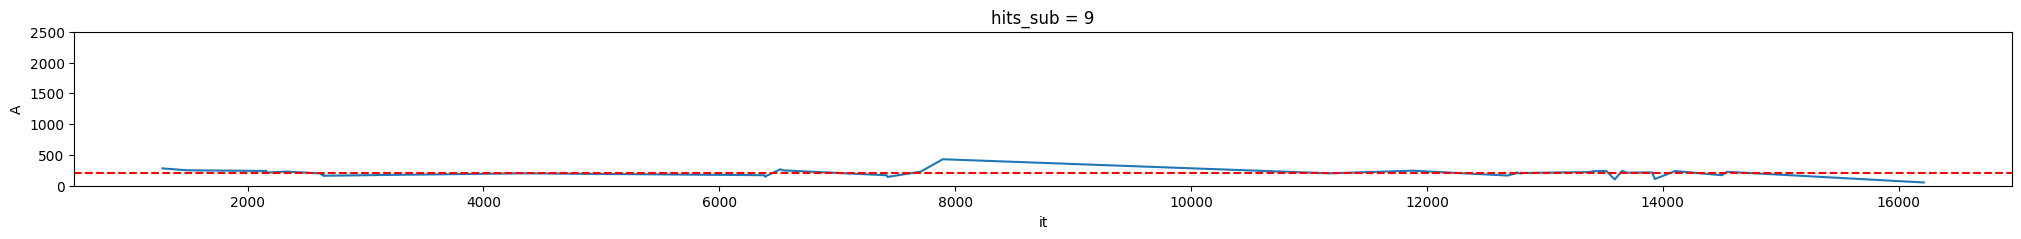

In [28]:
import matplotlib.pyplot as plt

# Assuming mouse_triangle is already defined
plt.figure(figsize=(25, 2))

# plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2) & (likelihood_show['mouse_triangle'] > 200)].sort_values(by='total_likelihood')
plot_df = likelihood_show[(likelihood_show['h_sub'] == 9)]
#plot_df = likelihood_show#.sort_values(by='total_likelihood')

plt.plot(plot_df['mouse_triangle'])

# Add labels and title
plt.xlabel('it')
plt.ylabel('A')
plt.title('hits_sub = 9')

plt.ylim(0, 2500)
# Define the threshold
threshold = 200

plt.axhline(y=threshold, color='r', linestyle='--')
# Show plot
plt.show()


* if sum of likelihoods for a label are less than 0.8 I don't think it's visible
* i want to see the evolution of distance between the projected 3d coordinates of the estimates and the likelihoods
# 

In [29]:
print(likelihood_show[likelihood_show['total_likelihood'] > 2]['mouse_triangle'].mean())
print(likelihood_show[likelihood_show['hits'] > 2]['mouse_triangle'].mean())

192.7936987433699
192.69413533760365


In [30]:
print(len(likelihood_show[(likelihood_show['hits'] > 1)]))
print(len(likelihood_show[(likelihood_show['hits'] == 3)]))

5531
2502


# i want to see in what frames the lockbox elements move

In [128]:
import pandas as pd
# Load the data
box_f = pd.read_hdf(hdf5_path_front)
box_s = pd.read_hdf(hdf5_path_side)
box_t = pd.read_hdf(hdf5_path_top)

columns_to_keep = ['lever_tip', 'upper_lever_tip', 'stick_head', 'ball', 'sliding_door']

box_f = box_f.loc[:, box_f.columns.get_level_values(1).isin(columns_to_keep)]
box_s = box_s.loc[:, box_s.columns.get_level_values(1).isin(columns_to_keep)]
box_t = box_t.loc[:, box_t.columns.get_level_values(1).isin(columns_to_keep)]

box_f.columns = box_f.columns.droplevel(0)
box_s.columns = box_s.columns.droplevel(0)
box_t.columns = box_t.columns.droplevel(0)

box_f.columns = box_f.columns.map('_'.join).str.strip('|')
box_s.columns = box_s.columns.map('_'.join).str.strip('|')
box_t.columns = box_t.columns.map('_'.join).str.strip('|')

In [131]:
# Stack the data
lever_tip_f = np.column_stack((box_f['lever_tip_x'], box_f['lever_tip_y']))
lever_tip_s = np.column_stack((box_s['lever_tip_x'], box_s['lever_tip_y']))
lever_tip_t = np.column_stack((box_t['lever_tip_x'], box_t['lever_tip_y']))

upper_lever_tip_f = np.column_stack((box_f['upper_lever_tip_x'], box_f['upper_lever_tip_y']))
upper_lever_tip_s = np.column_stack((box_s['upper_lever_tip_x'], box_s['upper_lever_tip_y']))
upper_lever_tip_t = np.column_stack((box_t['upper_lever_tip_x'], box_t['upper_lever_tip_y']))

stick_head_f = np.column_stack((box_f['stick_head_x'], box_f['stick_head_y']))
stick_head_s = np.column_stack((box_s['stick_head_x'], box_s['stick_head_y']))
stick_head_t = np.column_stack((box_t['stick_head_x'], box_t['stick_head_y']))

ball_f = np.column_stack((box_f['ball_x'], box_f['ball_y']))
ball_s = np.column_stack((box_s['ball_x'], box_s['ball_y']))
ball_t = np.column_stack((box_t['ball_x'], box_t['ball_y']))

sliding_door_f = np.column_stack((box_f['sliding_door_x'], box_f['sliding_door_y']))
sliding_door_s = np.column_stack((box_s['sliding_door_x'], box_s['sliding_door_y']))
sliding_door_t = np.column_stack((box_t['sliding_door_x'], box_t['sliding_door_y']))

# Likelihoods
lever_tip_lks = pd.DataFrame({'front': box_f['lever_tip_likelihood'], 'side': box_s['lever_tip_likelihood'], 'top': box_t['lever_tip_likelihood']})
upper_lever_tip_lks = pd.DataFrame({'front': box_f['upper_lever_tip_likelihood'], 'side': box_s['upper_lever_tip_likelihood'], 'top': box_t['upper_lever_tip_likelihood']})
stick_head_lks = pd.DataFrame({'front': box_f['stick_head_likelihood'], 'side': box_s['stick_head_likelihood'], 'top': box_t['stick_head_likelihood']})
ball_lks = pd.DataFrame({'front': box_f['ball_likelihood'], 'side': box_s['ball_likelihood'], 'top': box_t['ball_likelihood']})
sliding_door_lks = pd.DataFrame({'front': box_f['sliding_door_likelihood'], 'side': box_s['sliding_door_likelihood'], 'top': box_t['sliding_door_likelihood']})

# Triangulate points
lever_tip_3d = triangulate_points(lever_tip_f, lever_tip_s, lever_tip_t, P_front, P_side, P_top)
upper_lever_tip_3d = triangulate_points(upper_lever_tip_f, upper_lever_tip_s, upper_lever_tip_t, P_front, P_side, P_top)
stick_head_3d = triangulate_points(stick_head_f, stick_head_s, stick_head_t, P_front, P_side, P_top)
ball_3d = triangulate_points(ball_f, ball_s, ball_t, P_front, P_side, P_top)
sliding_door_3d = triangulate_points(sliding_door_f, sliding_door_s, sliding_door_t, P_front, P_side, P_top)

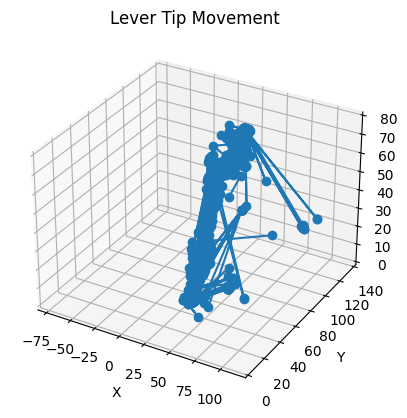

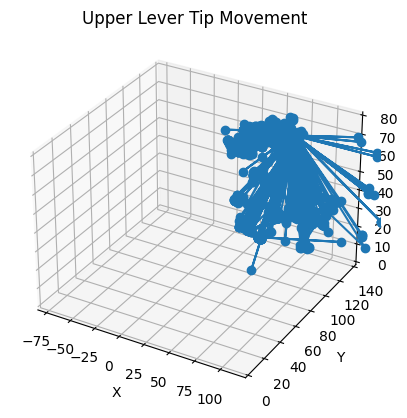

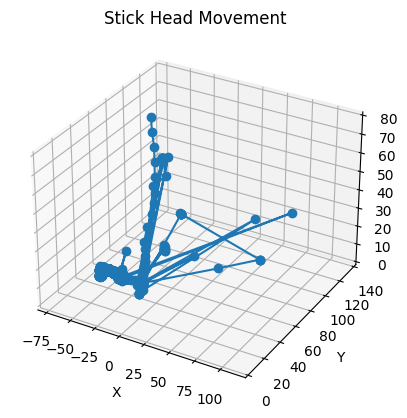

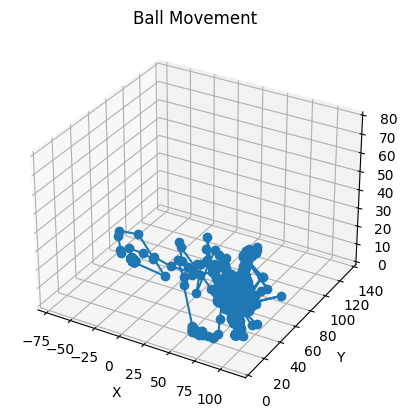

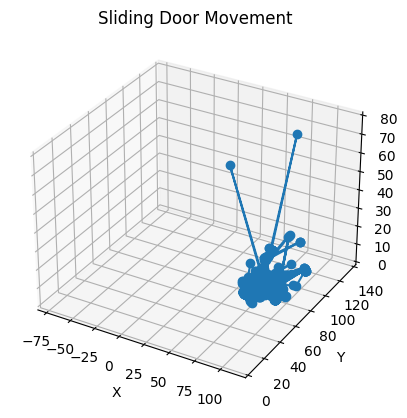

In [298]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
import numpy as np
from sklearn.neighbors import NearestNeighbors

def plot_3d_movements(points_3d, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], marker='o')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([-80, 120])
    ax.set_ylim([0, 140])
    ax.set_zlim([0, 80])
    plt.show()

def filter_points(points_3d, likelihoods, threshold=2):
    valid_indices = likelihoods.sum(axis=1) >= threshold
    return points_3d[valid_indices], np.where(valid_indices)[0]

# Apply filtering
lever_tip_3d_filtered, lever_tip_indices = filter_points(lever_tip_3d, lever_tip_lks)
upper_lever_tip_3d_filtered, upper_lever_tip_indices = filter_points(upper_lever_tip_3d, upper_lever_tip_lks)
stick_head_3d_filtered, stick_head_indices = filter_points(stick_head_3d, stick_head_lks)
ball_3d_filtered, ball_indices = filter_points(ball_3d, ball_lks)  # only likelihood filter for ball
sliding_door_3d_filtered, sliding_door_indices = filter_points(sliding_door_3d, sliding_door_lks)

# Plot movements
plot_3d_movements(lever_tip_3d_filtered, 'Lever Tip Movement')
plot_3d_movements(upper_lever_tip_3d_filtered, 'Upper Lever Tip Movement')
plot_3d_movements(stick_head_3d_filtered, 'Stick Head Movement')
plot_3d_movements(ball_3d_filtered, 'Ball Movement')
plot_3d_movements(sliding_door_3d_filtered, 'Sliding Door Movement')

In [391]:
import pandas as pd

# Convert filtered points and indices to DataFrame and set the original index as the DataFrame index
lever_tip_df = pd.DataFrame(lever_tip_3d_filtered, columns=['X', 'Y', 'Z'], index=lever_tip_indices)
upper_lever_tip_df = pd.DataFrame(upper_lever_tip_3d_filtered, columns=['X', 'Y', 'Z'], index=upper_lever_tip_indices)
stick_head_df = pd.DataFrame(stick_head_3d_filtered, columns=['X', 'Y', 'Z'], index=stick_head_indices)
ball_df = pd.DataFrame(ball_3d_filtered, columns=['X', 'Y', 'Z'], index=ball_indices)
sliding_door_df = pd.DataFrame(sliding_door_3d_filtered, columns=['X', 'Y', 'Z'], index=sliding_door_indices)

lever_tip_df = lever_tip_df[lever_tip_df.index >= 300]
upper_lever_tip_df = upper_lever_tip_df[upper_lever_tip_df.index >= 300]
stick_head_df = stick_head_df[stick_head_df.index >= 300]
ball_df = ball_df[ball_df.index >= 300]
sliding_door_df = sliding_door_df[sliding_door_df.index >= 300]

In [139]:
import numpy as np

def calculate_distance(df):
    d = []
    for i in range(len(df) - 1):
        dist = distance(
            [df.iloc[i]['X'], df.iloc[i]['Y'], df.iloc[i]['Z']],
            [df.iloc[i+1]['X'], df.iloc[i+1]['Y'], df.iloc[i+1]['Z']]
        )
        d.append(dist)
    d.append(0)
    df['dist'] = d

calculate_distance(lever_tip_df)
calculate_distance(upper_lever_tip_df)
calculate_distance(stick_head_df)
calculate_distance(ball_df)
calculate_distance(sliding_door_df)


In [140]:
lever_tip_df['p'] = lever_tip_lks.sum(axis=1)
upper_lever_tip_df['p'] = upper_lever_tip_lks.sum(axis=1)
stick_head_df['p'] = stick_head_lks.sum(axis=1)
ball_df['p'] = ball_lks.sum(axis=1)
sliding_door_df['p'] = sliding_door_lks.sum(axis=1)

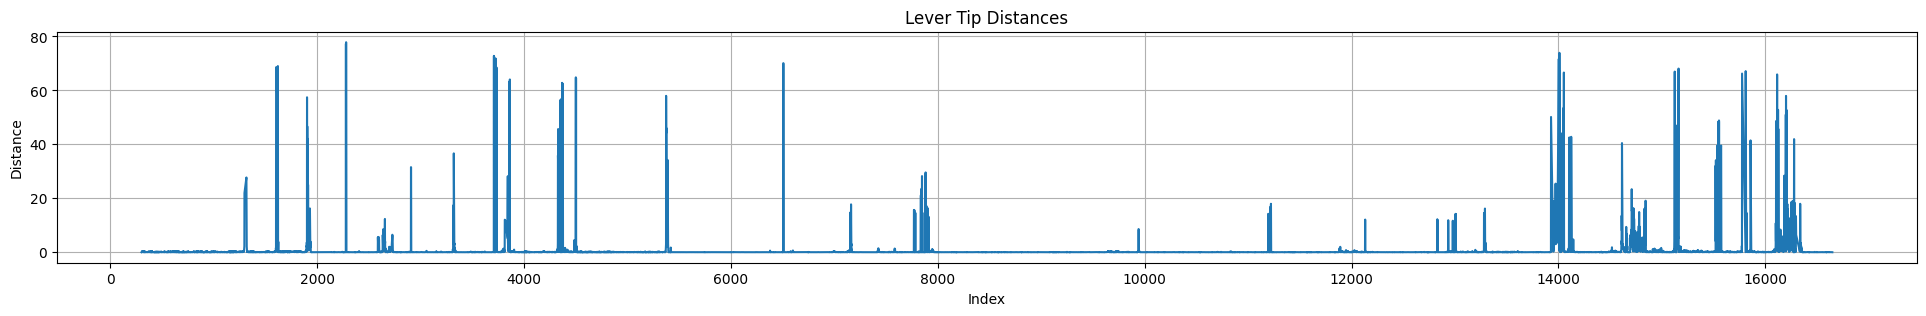

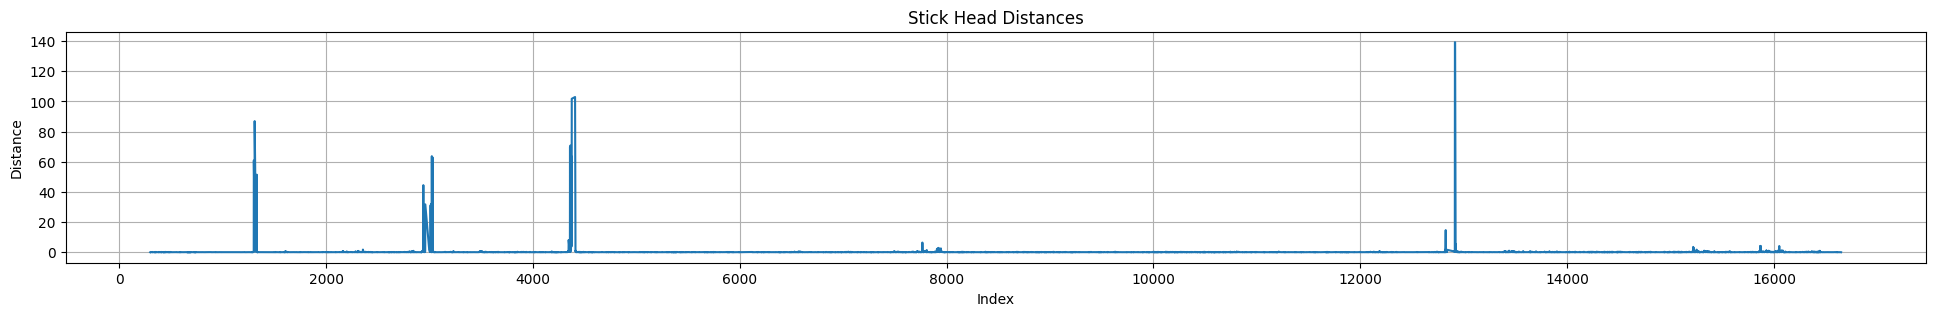

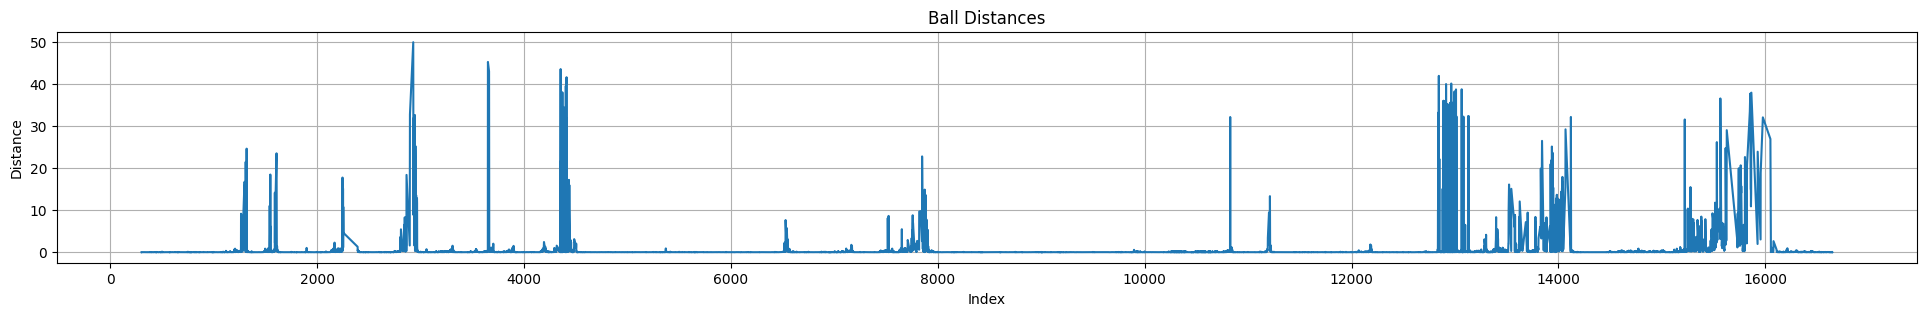

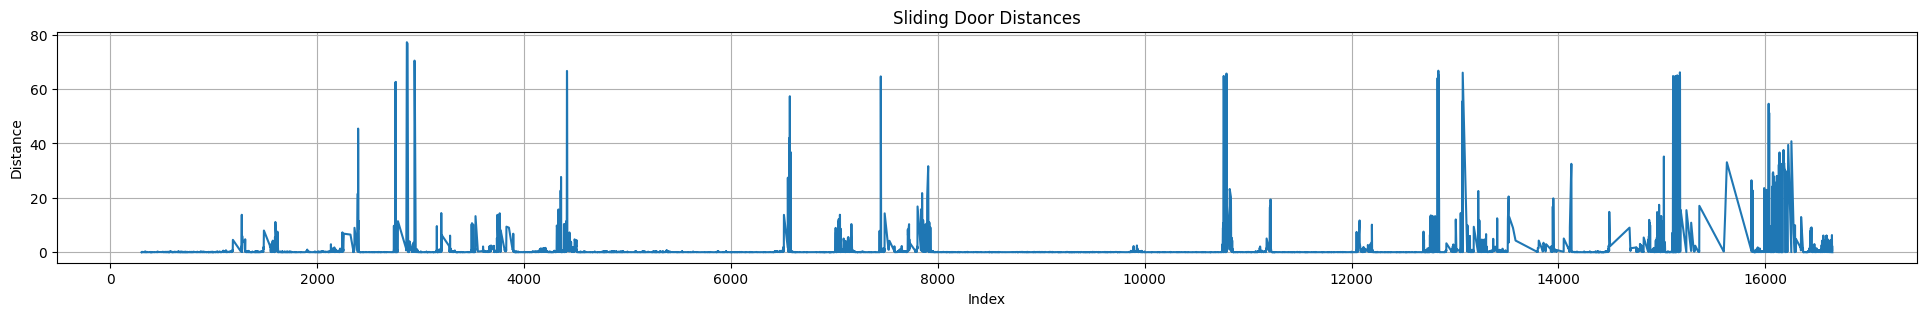

In [141]:
def plot_distances(df, title):
    plt.figure(figsize=(24,3))
    plt.plot(df.index, df['dist'])
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.grid(True)
    plt.show()

# Plot each DataFrame
plot_distances(lever_tip_df, 'Lever Tip Distances')
plot_distances(stick_head_df, 'Stick Head Distances')
plot_distances(ball_df, 'Ball Distances')
plot_distances(sliding_door_df, 'Sliding Door Distances')

In [142]:
data = np.load('/home/box/coding/CTIR/2021-03-05_08-22-05_manual_annotations.npz')
ethogram_interactions = data['ethogram_interactions']
annotator_data_1 = ethogram_interactions[0]
annotator_data_2 = ethogram_interactions[1]

In [389]:
annotator_lever_df = pd.DataFrame({'l1':annotator_data_1[0, 300:16650], 'l2':annotator_data_2[0, 300:16650]})
annotator_lever_df['sum'] = (annotator_lever_df['l1'].astype(bool) | annotator_lever_df['l2'].astype(bool)).astype(int)
annotator_lever_df.index = range(300, 300 + len(annotator_lever_df))

lever_tip_df_reindexed = lever_tip_df.reindex(annotator_lever_df.index, fill_value=0)

annotator_lever_df['d'] = (lever_tip_df_reindexed['dist'].apply(lambda x: 1 if x > 5 else 0)).astype(int)
annotator_lever_df

,l1,l2,sum,d
300,0.0,0.0,0,0
301,0.0,0.0,0,0
302,0.0,0.0,0,0
303,0.0,0.0,0,0
304,0.0,0.0,0,0
...,...,...,...,...
16645,0.0,0.0,0,0
16646,0.0,0.0,0,0
16647,0.0,0.0,0,0
16648,0.0,0.0,0,0


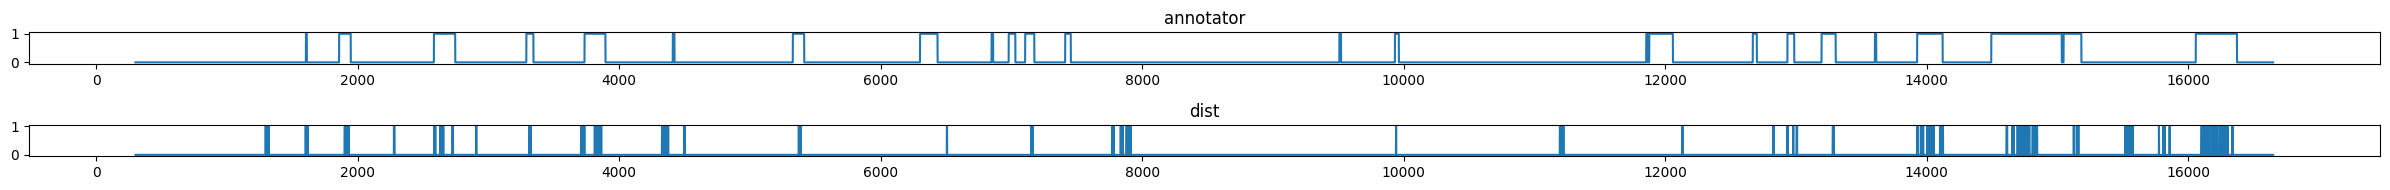

In [390]:
import matplotlib.pyplot as plt

# Assuming annotator_lever_df is already defined and contains 'sum' and 'd' columns.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 2))

ax1.plot(annotator_lever_df['sum'])
ax1.set_title('annotator')

ax2.plot(annotator_lever_df['d'])
ax2.set_title('dist')

plt.tight_layout()
plt.show()


# next i want to add the distance of the mouse head triangle to the lever

## first i need to define a bounding box for the lever

In [328]:
lever_tip_3d = pd.DataFrame(lever_tip_3d, columns=['x', 'y', 'z'])
upper_lever_tip_3d = pd.DataFrame(upper_lever_tip_3d, columns=['x', 'y', 'z'])

In [324]:
mouse_model_df = likelihood_show[['x','y','z']]
mouse_model_df

,x,y,z
0,18.293333,98.032958,28.304527
1,21.506125,98.527262,31.275892
2,22.253137,98.650836,31.115947
3,21.197166,98.494374,26.504290
4,19.820599,98.245211,27.262543
...,...,...,...
16645,86.876938,80.325598,37.427995
16646,87.319552,81.059413,38.261472
16647,87.757644,81.705175,38.242653
16648,92.426933,81.952631,37.895589


In [382]:
import numpy as np
import pandas as pd
from scipy.spatial import distance

def create_bounding_box_vertices(end1, end2, corner, width):
    vertices = np.array([
        end1,
        corner,
        end2,
        end1 + np.array([0, width, 0]),
        corner + np.array([0, width, 0]),
        end2 + np.array([0, width, 0]),
        end1 + np.array([0, 0, width]),
        corner + np.array([0, 0, width]),
        end2 + np.array([0, 0, width]),
        end1 + np.array([0, width, width]),
        corner + np.array([0, width, width]),
        end2 + np.array([0, width, width])
    ])
    return vertices

# Function to check if a point is within a radius of any point on the bounding box
def is_within_radius_of_bounding_box(point, vertices, radius=1.0):
    for vertex in vertices:
        dist = distance.euclidean(point, vertex)
        if dist <= radius:
            return 1
    return 0

# Define faces of the L shape
faces = [
    [0, 1, 4, 3],  # Front face from end1 to corner
    [1, 2, 5, 4],  # Front face from corner to end2
    [0, 3, 9, 6],  # Side face from end1, bottom
    [1, 4, 10, 7], # Side face from corner, bottom
    [2, 5, 11, 8], # Side face from end2, bottom
    [3, 4, 10, 9], # Top face corner region
    [4, 5, 11, 10], # Top face end2 region
    [6, 7, 10, 9], # Bottom face corner region
    [7, 8, 11, 10], # Bottom face end2 region
    [0, 6, 7, 1],  # Vertical side face end1 to corner
    [1, 7, 8, 2],  # Vertical side face corner to end2
]

# Iterate through all frames and compare
radius = 23
width = 10
results = []

for ind in range(len(mouse_model_df)):
    mouse_point = np.array([mouse_model_df.loc[ind, 'x'], mouse_model_df.loc[ind, 'y'], mouse_model_df.loc[ind, 'z']])
    end1 = np.array([lever_tip_3d.loc[ind, 'x'], lever_tip_3d.loc[ind, 'y'], lever_tip_3d.loc[ind, 'z']])
    end2 = np.array([upper_lever_tip_3d.loc[ind, 'x'], upper_lever_tip_3d.loc[ind, 'y'], upper_lever_tip_3d.loc[ind, 'z']])
    corner = np.array([91.55, 79.63, 55.64])  # Assuming corner is constant, modify if needed
    
    vertices = create_bounding_box_vertices(end1, end2, corner, width)
    close_flag = is_within_radius_of_bounding_box(mouse_point, vertices, radius)
    results.append(close_flag)

# Add results to the DataFrame
mouse_model_df['m'] = results


/tmp/ipykernel_771541/981772062.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_model_df['m'] = results


In [383]:
annotator_lever_df['m'] = mouse_model_df['m'][300:]
annotator_lever_df

,l1,l2,sum,d,m
300,0.0,0.0,0,0,0
301,0.0,0.0,0,0,0
302,0.0,0.0,0,0,0
303,0.0,0.0,0,0,0
304,0.0,0.0,0,0,0
...,...,...,...,...,...
16645,0.0,0.0,0,0,1
16646,0.0,0.0,0,0,1
16647,0.0,0.0,0,0,1
16648,0.0,0.0,0,0,1


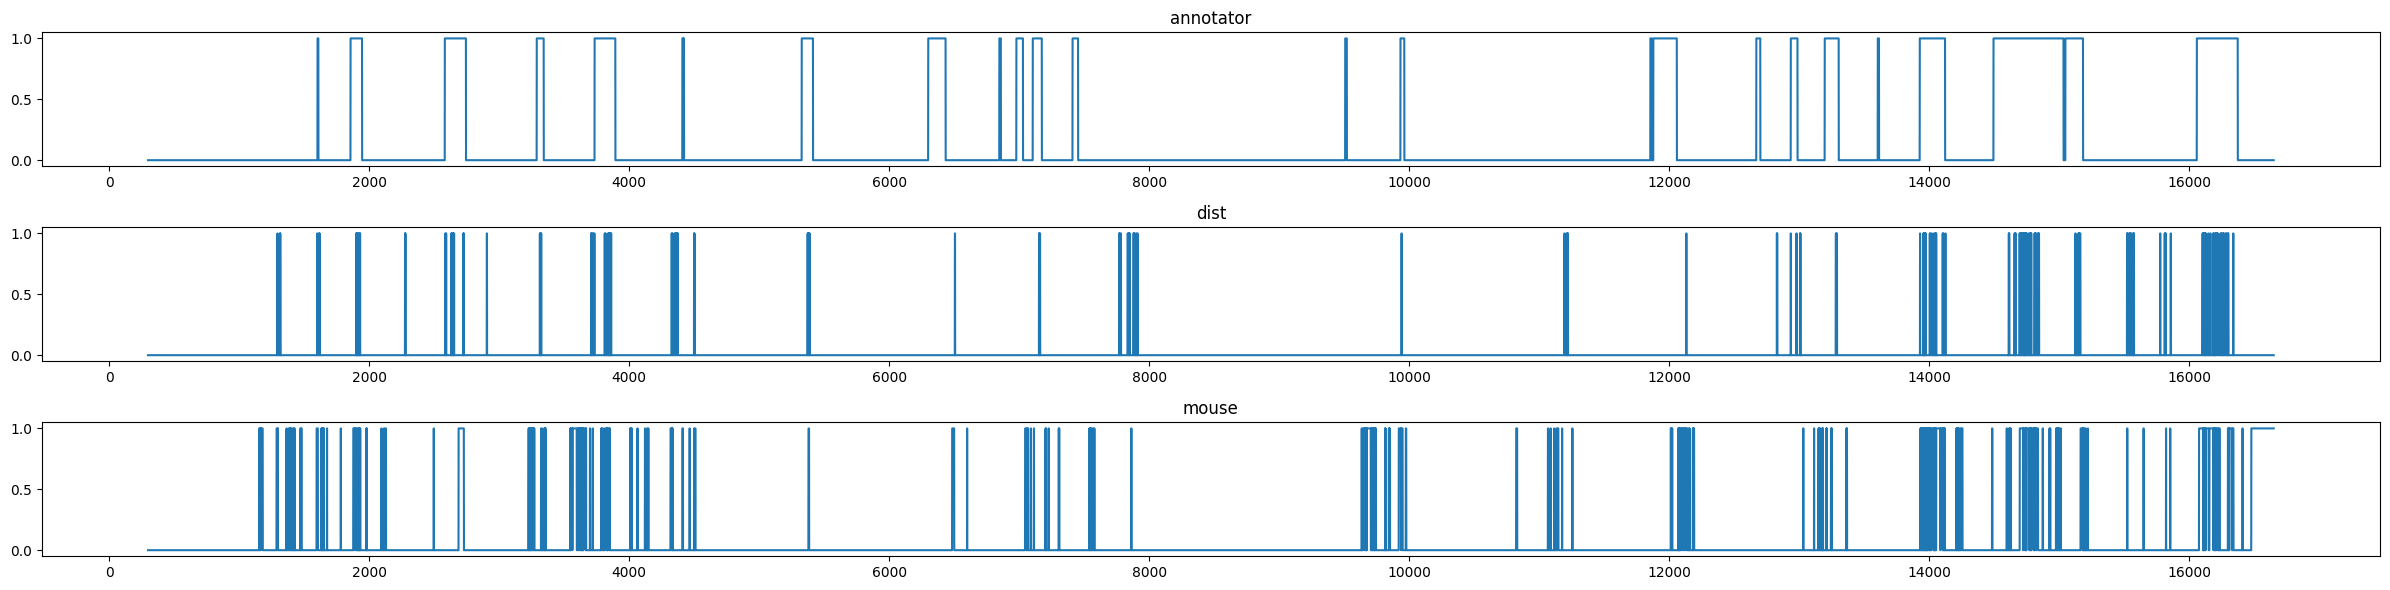

In [384]:
import matplotlib.pyplot as plt

# Assuming annotator_lever_df is already defined and contains 'sum' and 'd' columns.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 6))

ax1.plot(annotator_lever_df['sum'])
ax1.set_title('annotator')

ax2.plot(annotator_lever_df['d'])
ax2.set_title('dist')

ax3.plot(annotator_lever_df['m'])
ax3.set_title('mouse')

plt.tight_layout()
plt.show()

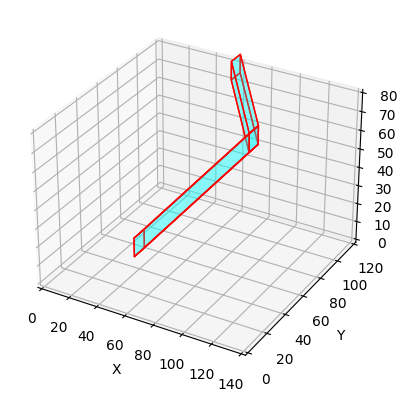

In [393]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Coordinates for the ends and the angle bracket corner
ind = 800
end1 = np.array([lever_tip_df.loc[ind, 'X'], lever_tip_df.loc[ind, 'Y'], lever_tip_df.loc[ind, 'Z']])
end2 = np.array([upper_lever_tip_df.loc[ind, 'X'], upper_lever_tip_df.loc[ind, 'Y'], upper_lever_tip_df.loc[ind, 'Z']])
corner = np.array([91.55, 79.63, 55.64])

# Custom width
width = 10

# Create L shape vertices
vertices = np.array([
    end1,
    corner,
    end2,
    end1 + np.array([0, width, 0]),
    corner + np.array([0, width, 0]),
    end2 + np.array([0, width, 0]),
    end1 + np.array([0, 0, width]),
    corner + np.array([0, 0, width]),
    end2 + np.array([0, 0, width]),
    end1 + np.array([0, width, width]),
    corner + np.array([0, width, width]),
    end2 + np.array([0, width, width])
])

# Define faces of the L shape
faces = [
    [0, 1, 4, 3],  # Front face from end1 to corner
    [1, 2, 5, 4],  # Front face from corner to end2
    [0, 3, 9, 6],  # Side face from end1, bottom
    [1, 4, 10, 7], # Side face from corner, bottom
    [2, 5, 11, 8], # Side face from end2, bottom
    [3, 4, 10, 9], # Top face corner region
    [4, 5, 11, 10], # Top face end2 region
    [6, 7, 10, 9], # Bottom face corner region
    [7, 8, 11, 10], # Bottom face end2 region
    [0, 6, 7, 1],  # Vertical side face end1 to corner
    [1, 7, 8, 2],  # Vertical side face corner to end2
]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

poly3d = [[vertices[vert_idx] for vert_idx in face] for face in faces]
ax.add_collection3d(Poly3DCollection(poly3d, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-100, 120])
ax.set_ylim([0, 140])
ax.set_zlim([0, 80])

plt.show()

In [283]:
import pandas as pd
import numpy as np

def find_corner_point(P1, P2):
    P1 = np.array(P1)
    P2 = np.array(P2)
    
    M = (P1 + P2) / 2
    vector_P1_P2 = P2 - P1
    perpendicular_vector = np.cross(vector_P1_P2, [0, 0, 1])
    perpendicular_vector = perpendicular_vector / np.linalg.norm(perpendicular_vector)
    
    length = np.linalg.norm(vector_P1_P2) / 2
    C = M + perpendicular_vector * length
    
    return C

def average_corner_point(df1, df2):
    corner_points = []

    common_indices = df1.index.intersection(df2.index)
    
    for idx in common_indices:
        P1 = df1.loc[idx].values
        P2 = df2.loc[idx].values
        corner_point = find_corner_point(P1, P2)
        corner_points.append(corner_point)
    
    average_corner = np.mean(corner_points, axis=0)
    return average_corner

# Example data
data1 = lever_tip_df[['X','Y','Z']][(lever_tip_df['p'] > 2.5)& (lever_tip_df['dist'] < 3)]

data2 = upper_lever_tip_df[['X','Y','Z']][(upper_lever_tip_df['p'] > 2.5) & (upper_lever_tip_df['dist'] < 3)]

# Calculating average corner point
average_corner = average_corner_point(data1, data2)
print("Average Corner Point:", average_corner)


Average Corner Point: [91.55688935 79.63904458 55.64310263]


In [290]:
d1 = []
for index, row in data1.iterrows():
    d1.append(distance(average_corner, [row['X'], row['Y'], row['Z']]))

d2 = []
for index, row in data2.iterrows():
    d2.append(distance(average_corner, [row['X'], row['Y'], row['Z']]))


In [291]:
from statistics import median, mean

print(median(d1))
print(mean(d1))
print()
print(median(d2))
print(mean(d2))

50.11040439386754
59.92736103115385

49.01669131399539
62.27554411865907


In [125]:
likelihood_show

,mouse_triangle,x,y,z,nose_likelihood,ear_left_likelihood,ear_right_likelihood,total_likelihood,hits,f_n,...,t_e_l,f_e_r,s_e_r,t_e_r,h_n,h_e_l,h_e_r,h_sub,low,dist
0,510.143797,18.293333,98.032958,28.304527,0.232079,0.082116,0.382408,0.696603,0,0.000497,...,0.079648,0.000174,0.009064,0.373170,0,0,0,0,0,0.0
1,862.022677,21.506125,98.527262,31.275892,0.234335,0.081843,0.377942,0.694119,0,0.000543,...,0.079561,0.000187,0.007295,0.370460,0,0,0,0,0,0.0
2,900.636488,22.253137,98.650836,31.115947,0.204676,0.081438,0.376221,0.662335,0,0.000557,...,0.079165,0.000179,0.007964,0.368077,0,0,0,0,0,0.0
3,532.066075,21.197166,98.494374,26.504290,0.239928,0.082482,0.377188,0.699598,0,0.000557,...,0.079774,0.000179,0.009588,0.367421,0,0,0,0,0,0.0
4,521.529149,19.820599,98.245211,27.262543,0.413909,0.086666,0.382471,0.883045,0,0.000555,...,0.084018,0.000180,0.007640,0.374651,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16645,204.458310,86.876938,80.325598,37.427995,2.069458,1.473258,1.984043,5.526758,2,0.083187,...,0.690304,0.983060,0.004904,0.996079,2,1,2,5,1,0.0
16646,219.130509,87.319552,81.059413,38.261472,1.993340,1.529322,2.002739,5.525402,3,0.005777,...,0.600655,0.991955,0.016031,0.994754,2,1,2,5,1,0.0
16647,234.516213,87.757644,81.705175,38.242653,1.998704,0.542906,1.992130,4.533740,2,0.008851,...,0.334450,0.983849,0.016519,0.991762,2,0,2,4,0,0.0
16648,86.655943,92.426933,81.952631,37.895589,1.995955,0.497924,1.994703,4.488582,2,0.005748,...,0.369369,0.993513,0.017919,0.983271,2,0,2,4,0,0.0


In [ ]:
annotator_lever_df = pd.DataFrame({'l1':annotator_data_1[0, 300:16650], 'l2':annotator_data_2[0, 300:16650]})
annotator_lever_df['sum'] = (annotator_lever_df['l1'].astype(bool) | annotator_lever_df['l2'].astype(bool)).astype(int)
annotator_lever_df.index = range(300, 300 + len(annotator_lever_df))

lever_tip_df_reindexed = lever_tip_df.reindex(annotator_lever_df.index, fill_value=0)

annotator_lever_df['d'] = (lever_tip_df_reindexed['dist'].apply(lambda x: 1 if x > 5 else 0)).astype(int)
annotator_lever_df

# mean of total likelihood > 2 gives us a good estimate of the area of the nose-ear-ear triangle

In [ ]:
# if there are more than 2 good measurements(1.5?) AND Area is close to the good mean (5%?) we use those as hypothesis
# from there if likelihood of triangle corner drops below threshhold(1.5?) use 

In [ ]:
import matplotlib.pyplot as plt

# Assuming mouse_triangle is already defined
plt.figure(figsize=(25, 2))

# plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2) & (likelihood_show['mouse_triangle'] > 200)].sort_values(by='total_likelihood')
plot_df = likelihood_show[(likelihood_show['hits'] == 3)]#.sort_values(by='total_likelihood')
#plot_df = likelihood_show#.sort_values(by='total_likelihood')

#plt.plot(mouse_triangle)
#plt.plot(plot_df['total_likelihood'],plot_df['mouse_triangle'])
plt.plot(plot_df['mouse_triangle'])

# Add labels and title
plt.xlabel('it')
plt.ylabel('A')
plt.title('triangle area, exactly 3 good measurements')

# Cut off y axis at 20000
plt.ylim(0, 2500)
# Define the threshold
threshold = 200

plt.axhline(y=threshold, color='r', linestyle='--')

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming mouse_triangle is already defined
plt.figure(figsize=(25, 2))

# plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2) & (likelihood_show['mouse_triangle'] > 200)].sort_values(by='total_likelihood')
plot_df = likelihood_show[(likelihood_show['hits'] == 2)]#.sort_values(by='total_likelihood')
#plot_df = likelihood_show#.sort_values(by='total_likelihood')

#plt.plot(mouse_triangle)
#plt.plot(plot_df['total_likelihood'],plot_df['mouse_triangle'])
plt.plot(plot_df['mouse_triangle'])

# Add labels and title
plt.xlabel('it')
plt.ylabel('A')
plt.title('triangle area, exactly 2 good measurements')

# Cut off y axis at 20000
plt.ylim(0, 2500)
# Define the threshold
threshold = 200

plt.axhline(y=threshold, color='r', linestyle='--')

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming mouse_triangle is already defined
plt.figure(figsize=(25, 2))

# plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2) & (likelihood_show['mouse_triangle'] > 200)].sort_values(by='total_likelihood')
plot_df = likelihood_show[(likelihood_show['hits'] > 1)]#.sort_values(by='total_likelihood')
#plot_df = likelihood_show#.sort_values(by='total_likelihood')

#plt.plot(mouse_triangle)
#plt.plot(plot_df['total_likelihood'],plot_df['mouse_triangle'])
plt.plot(plot_df['mouse_triangle'])

# Add labels and title
plt.xlabel('it')
plt.ylabel('A')
plt.title('triangle area, at least 2 good measurements')

# Cut off y axis at 20000
plt.ylim(0, 2500)
# Define the threshold
threshold = 200

plt.axhline(y=threshold, color='r', linestyle='--')

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming mouse_triangle is already defined
plt.figure(figsize=(25, 2))

# plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2) & (likelihood_show['mouse_triangle'] > 200)].sort_values(by='total_likelihood')
plot_df = likelihood_show[(likelihood_show['hits'] > 1)]#.sort_values(by='total_likelihood')
#plot_df = likelihood_show#.sort_values(by='total_likelihood')

#plt.plot(mouse_triangle)
#plt.plot(plot_df['total_likelihood'],plot_df['mouse_triangle'])
plt.plot(plot_df['total_likelihood'])

# Add labels and title
plt.xlabel('it')
plt.ylabel('p')
plt.title('total_likelihood, at least 2 good measurements')

# Cut off y axis at 20000
plt.ylim(0, 9)
# Define the threshold
threshold = 4

plt.axhline(y=threshold, color='r', linestyle='--')

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming mouse_triangle is already defined
plt.figure(figsize=(25, 2))

# plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2) & (likelihood_show['mouse_triangle'] > 200)].sort_values(by='total_likelihood')
#plot_df = likelihood_show[(likelihood_show['total_likelihood'] > 2)].sort_values(by='total_likelihood')
plot_df = likelihood_show#.sort_values(by='total_likelihood')

#plt.plot(mouse_triangle)
#plt.plot(plot_df['total_likelihood'],plot_df['mouse_triangle'])
plt.plot(plot_df['total_likelihood'])

# Add labels and title
plt.xlabel('it')
plt.ylabel('p')
plt.title('total_likelihood')

# Cut off y axis at 20000
plt.ylim(0, 9)
# Define the threshold
threshold = 2

plt.axhline(y=2, color='r', linestyle='--')

# Show plot
plt.show()


In [ ]:
# next check out what happens to the area if we adjust for likelihood of reading if we have 2 good readings to instead make one up with the expected range! See what we get for area if all likelihoods are up(sum ~3)